In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.abspath(os.path.dirname("__file__")), '..'))
from fastai.vision.all import *
from fastai.vision.models import *
from pathlib import Path
from utils import data_handling, exploratory_data_analysis
from albumentations import ShiftScaleRotate
import pandas as pd
import numpy as np
import random
from IPython.core.debugger import set_trace

In [2]:
path = Path('/home/khoa-ys/Projects/auto_inspection/research/data')
images_path = path/'images'
labels_path = path/'labels.csv'

In [3]:
cell_images, cell_labels, cell_types = data_handling.load_data_from_file('../data/labels.csv', True)


vgg_body = create_body(vgg19_bn(), pretrained=True)
vgg19_mod = nn.Sequential(*list(vgg_body.children())[0], 
              nn.AdaptiveAvgPool2d((1,1)), 
              nn.Linear(512, 4096), 
              nn.ReLU(),
              nn.Dropout(0.2),
              nn.Linear(4096, 4096),
              nn.ReLU(),
              nn.Dropout(0.2),
              nn.Linear(4096, 4096),
              nn.ReLU(),
              nn.Dropout(0.2),
              nn.Linear(4096, 512),
              nn.ReLU(),
              nn.Linear(512, 1),
              nn.Sigmoid())
vgg19_mod

In [5]:
def get_model(model, pretrained=True):
    m = model
    return m

In [6]:
vgg19_mod = create_vision_model(arch = vgg19_bn, pretrained=True, cut=1, n_out = None, first_bn=False, pool=False, concat_pool=False,
                    custom_head=nn.Sequential(nn.AdaptiveAvgPool2d((1,1)), 
                                              nn.Linear(2048, 4096), 
                                              nn.ReLU(),
                                              nn.Dropout(0.2),
                                              nn.Linear(4096, 4096),
                                              nn.ReLU(),
                                              nn.Dropout(0.2),
                                              nn.Linear(4096, 4096),
                                              nn.ReLU(),
                                              nn.Dropout(0.2),
                                              nn.Linear(4096, 512),
                                              nn.ReLU(),
                                              nn.Linear(512, 4),
                                              nn.Sigmoid()))
vgg19_mod = partial(get_model, model=vgg19_mod)
vgg19_mod

functools.partial(<function get_model at 0x7f815d667310>, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)

resnet152_body = create_body(resnet152(), pretrained=True)
resnet152v2 = nn.Sequential(*list(resnet152(pretrained=True).children())[:-2], 
              nn.AdaptiveAvgPool2d((1,1)), 
              nn.Linear(2048, 4096), 
              nn.ReLU(),
              nn.Dropout(0.2),
              nn.Linear(4096, 4096),
              nn.ReLU(),
              nn.Dropout(0.2),
              nn.Linear(4096, 4096),
              nn.ReLU(),
              nn.Dropout(0.2),
              nn.Linear(4096, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Sigmoid())

In [7]:
metadata = pd.read_csv(labels_path, delim_whitespace=True, header=None)
metadata.columns = ['im_path', 'quality', 'cell type']
metadata.quality = metadata["quality"].map(lambda value: 1. if int(value) > 0 else 0.)
metadata['valid'] = [False]*int(len(metadata)*0.85) + [True]*int(len(metadata)*0.15+1)
metadata

,im_path,quality,cell type,valid
0,images/cell0001.png,1.0,mono,False
1,images/cell0002.png,1.0,mono,False
2,images/cell0003.png,1.0,mono,False
3,images/cell0004.png,0.0,mono,False
4,images/cell0005.png,1.0,mono,False
...,...,...,...,...
2619,images/cell2620.png,0.0,poly,True
2620,images/cell2621.png,0.0,poly,True
2621,images/cell2622.png,0.0,poly,True
2622,images/cell2623.png,0.0,poly,True


In [8]:
class CustomTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        p = np.random.uniform(0, 1)
        return PILImage.create.create(self.aug(image=np.array(img))['image'])
shift = CustomTransform(ShiftScaleRotate(shift_limit= 0.05))
tfms=[Dihedral(),
      Flip(),
      Rotate(draw=random.choices([-90, 90])[0]),
      Zoom(min_zoom=0.95, max_zoom = 1.05)]
[IntToFloatTensor(div_mask=255), *tfms, shift]

[IntToFloatTensor -- {'div': 255.0, 'div_mask': 255}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 decodes: (TensorImage,object) -> decodes,
 Dihedral -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encode

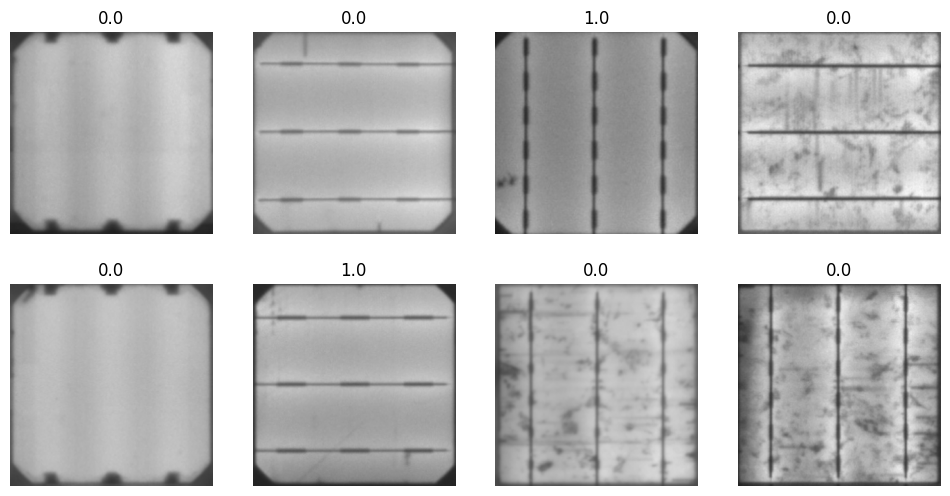

In [9]:
dls = ImageDataLoaders.from_df(metadata, path, label_col=1, valid_col = 3, bs=8,
                               batch_tfms=[IntToFloatTensor(div_mask=255), *tfms, shift],
                               valid_pct=0.0)
dls.show_batch()

In [10]:
# Custom NAdam
def sgd_step(p, lr, **kwargs):
    p.data.add_(p.grad.data, alpha=-lr)
    
def weight_decay(p, lr, wd, do_wd=True, **kwargs):
    "Weight decay as decaying `p` with `lr*wd`"
    if do_wd and wd!=0: p.data.mul_(1 - lr*wd)

weight_decay.defaults = dict(wd=0.)


def l2_reg(p, lr, wd, do_wd=True, **kwargs):
    "L2 regularization as adding `wd*p` to `p.grad`"
    if do_wd and wd!=0: p.grad.data.add_(p.data, alpha=wd)

l2_reg.defaults = dict(wd=0.)


def average_grad(p, mom, dampening=False, grad_avg=None, **kwargs):
    "Keeps track of the avg grads of `p` in `state` with `mom`."
    if grad_avg is None: grad_avg = torch.zeros_like(p.grad.data)
    damp = 1-mom if dampening else 1.
    grad_avg.mul_(mom).add_(p.grad.data, alpha=damp)
    return {'grad_avg': grad_avg}

average_grad.defaults = dict(mom=0.9)


def average_sqr_grad(p, sqr_mom, dampening=True, sqr_avg=None, **kwargs):
    if sqr_avg is None: sqr_avg = torch.zeros_like(p.grad.data)
    damp = 1-sqr_mom if dampening else 1.
    sqr_avg.mul_(sqr_mom).addcmul_(p.grad.data, p.grad.data, value=damp)
    return {'sqr_avg': sqr_avg}

average_sqr_grad.defaults = dict(sqr_mom=0.99)


def step_stat(p, step=0, **kwargs):
    "Register the number of steps done in `state` for `p`"
    step += 1
    return {'step' : step}



def debias(mom, damp, step): return damp * (1 - mom**step) / (1-mom)


def nadam_step(p, lr, mom, step, sqr_mom, grad_avg, sqr_avg, eps, **kwargs):
    #set_trace()
    debias1 = debias(mom,     1-mom,     step)
    debias2 = debias(sqr_mom, 1-sqr_mom, step)
    num = grad_avg.mul(mom).add(p.grad.data, alpha=(1-mom))
    p.data.addcdiv_(num, (sqr_avg/debias2).sqrt() + eps, value=-lr/debias1)
    

def NAdam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-8, wd=0.01, decouple_wd=True):
    cbs = [weight_decay] if decouple_wd else [l2_reg]
    cbs += [partial(average_grad, dampening=True), average_sqr_grad, step_stat, nadam_step]
    return Optimizer(params, cbs, lr=lr, mom=mom, sqr_mom=sqr_mom, eps=eps, wd=wd)

In [11]:
learn = vision_learner(dls, vgg19_mod, pretrained=True, opt_func=Adam)
learn.fine_tune(200, freeze_epochs = 200, base_lr=0.001)
learn.save('vgg19_Adam')

epoch,train_loss,valid_loss,time
0,0.972225,0.383475,00:27
1,0.810293,0.272091,00:27
2,0.874697,0.256711,00:27
3,0.768485,0.249085,00:28
4,0.713722,0.222458,00:27
5,0.704118,0.241319,00:27
6,0.674903,0.231106,00:27
7,0.666057,0.237734,00:27
8,0.598031,0.217206,00:27
9,0.668214,0.243436,00:27


epoch,train_loss,valid_loss,time
0,0.247005,0.190703,00:35
1,0.308369,0.180140,00:35
2,0.251444,0.174195,00:35
3,0.275277,0.195783,00:35
4,0.283601,0.193331,00:35
5,0.286603,0.204753,00:35
6,0.223838,0.192478,00:35
7,0.228246,0.180215,00:35
8,0.302517,0.158475,00:35
9,0.223973,0.183873,00:35


Path('/home/khoa-ys/Projects/auto_inspection/research/data/models/vgg19_Adam.pth')

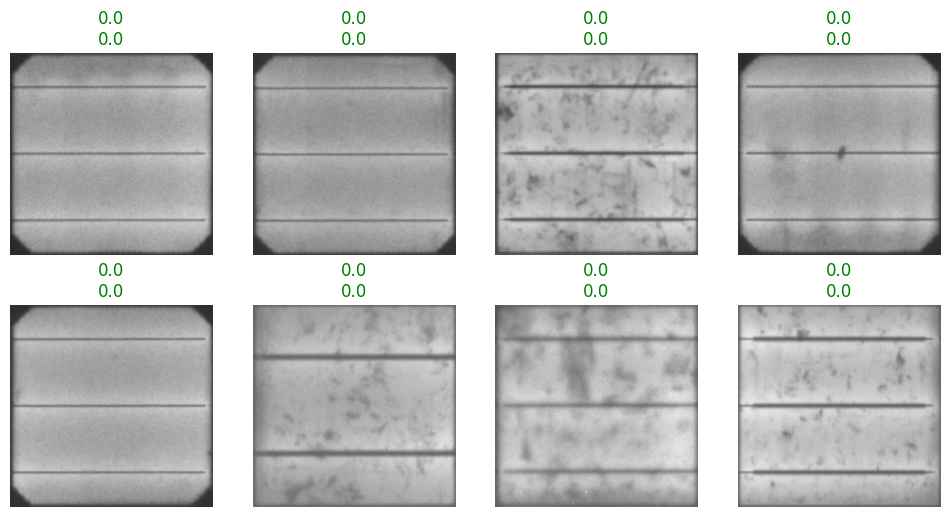

In [12]:
learn = vision_learner(dls, vgg19_mod, pretrained=True, opt_func=Adam)
learn.load('vgg19_Adam')
learn.show_results()

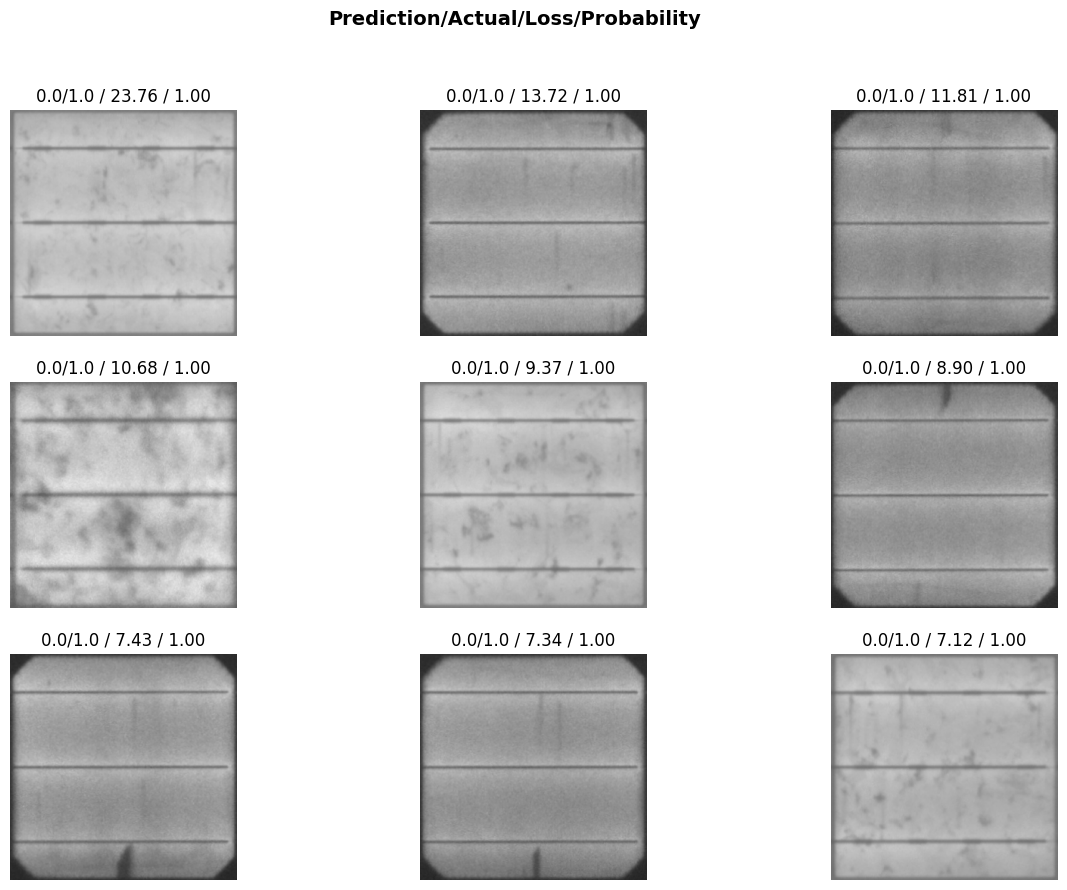

In [13]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

In [16]:
learn = vision_learner(dls, vgg19_mod, pretrained=True, opt_func=NAdam)
learn.fine_tune(200, freeze_epochs = 200, base_lr=0.001)
learn.save('vgg19_NAdam')

epoch,train_loss,valid_loss,time
0,0.441751,0.225118,00:27
1,0.440795,0.172471,00:27
2,0.385877,0.177021,00:27
3,0.405505,0.188021,00:27
4,0.310059,0.180704,00:27
5,0.298155,0.199603,00:27
6,0.295557,0.224619,00:27
7,0.264984,0.201995,00:28
8,0.304065,0.185653,00:29
9,0.261388,0.194835,00:27


epoch,train_loss,valid_loss,time
0,0.059894,0.269220,00:35
1,0.073427,0.249989,00:36
2,0.078965,0.260848,00:38
3,0.068466,0.315759,00:37
4,0.058715,0.272272,00:37
5,0.058240,0.299938,00:37
6,0.090705,0.286073,00:37
7,0.100161,0.254869,00:36
8,0.097573,0.320944,00:37
9,0.082700,0.304334,00:37


Path('/home/khoa-ys/Projects/auto_inspection/research/data/models/vgg19_NAdam.pth')

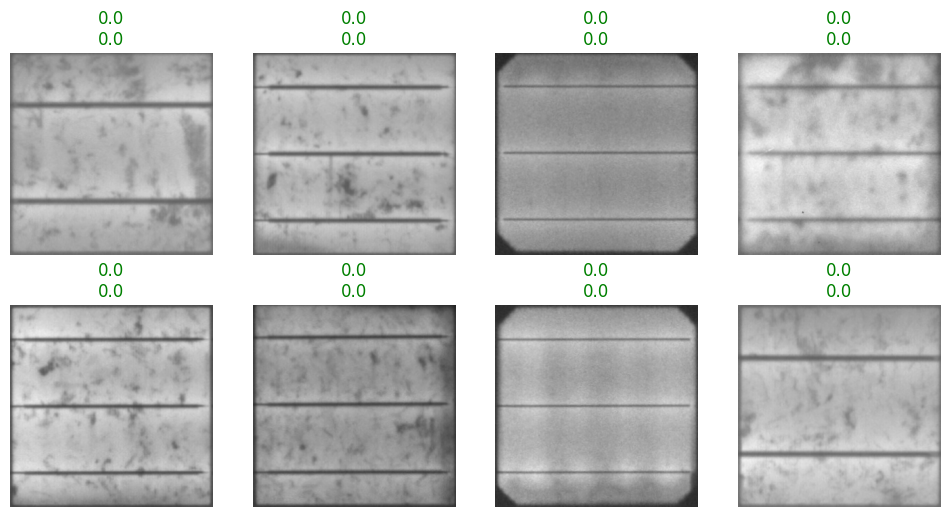

In [17]:
learn = vision_learner(dls, vgg19_mod, pretrained=True, opt_func=NAdam)
learn.load('vgg19_NAdam')
learn.show_results()

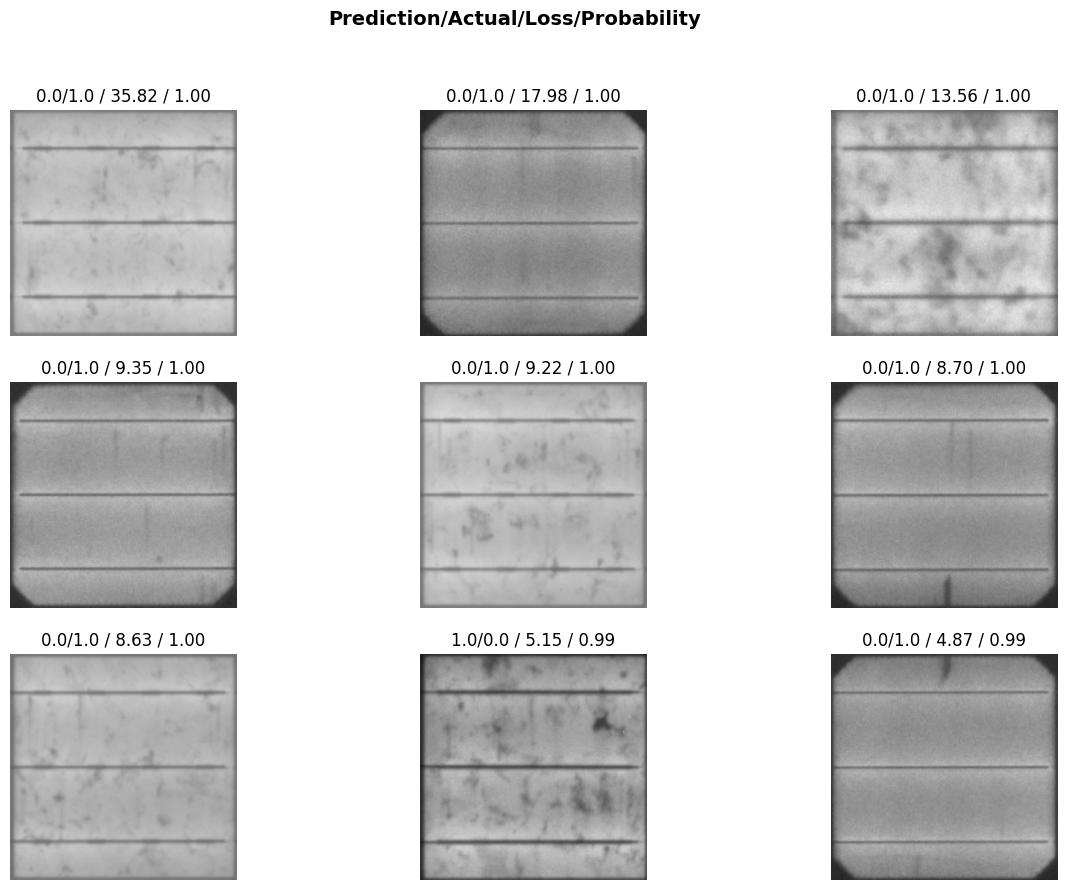

In [18]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))